In [32]:
import pandas as pd

data = pd.read_csv("database.csv")

print(data.shape[0])

440


In [33]:
data = data.dropna()
data['시초/공모(%)'] = pd.to_numeric(data['시초/공모(%)'].str.replace('%',''), errors='coerce')
data['공모가(원)'] = pd.to_numeric(data['공모가(원)'].str.replace(',',''), errors='coerce')
data['시초가(원)'] = pd.to_numeric(data['시초가(원)'].str.replace(',',''), errors='coerce')
data['첫날종가(원)'] = pd.to_numeric(data['첫날종가(원)'].str.replace(',',''), errors='coerce')
data['상장주식수'] = pd.to_numeric(data['상장주식수'].str.replace(',',''), errors='coerce')
data['경쟁률'] = pd.to_numeric(data['경쟁률'].str.replace(':1',''), errors='coerce')
data = data.dropna()

assert data.isnull().sum().sum() == 0
print(data.shape[0])

317


In [34]:
data = data[data['기업명'].str.contains('스팩') == False]
print(data.shape[0])

248


In [35]:
# 상장일 고가 > 시초가(원) & 상장일 고가 > 첫날종가(원)
data = data[(data["상장일 고가"] >= data["시초가(원)"]) & (data["상장일 고가"] >= data["첫날종가(원)"]) & (data["상장일 저가"] <= data["첫날종가(원)"])]

print(data.shape[0])

185


In [36]:
print("총 데이터 개수: ", data.shape[0])
print("시작 날짜: ", data['신규상장일'].min())
print("종료 날짜: ", data['신규상장일'].max())

총 데이터 개수:  185
시작 날짜:  2021-04-01
종료 날짜:  2024-11-20


In [37]:
data["종가/시가(%)"] = (data["첫날종가(원)"] / data["시초가(원)"] * 100 - 100).round(2)
data["고가/시가(%)"] = (data["상장일 고가"] / data["시초가(원)"] * 100 - 100).round(2)
data["저가/시가(%)"] = (data["상장일 저가"] / data["시초가(원)"] * 100 - 100).round(2)
data["고가/공모(%)"] = (data["상장일 고가"] / data["공모가(원)"] * 100 - 100).round(2)
data["종가/공모(%)"] = (data["첫날종가(원)"] / data["공모가(원)"] * 100 - 100).round(2)
data["시가총액(억)"] = ((data["상장주식수"] * data["공모가(원)"]) / 100000000).round(2)
data["20일후 종가/공모(%)"] = (
    data["20일후 종가"] / data["공모가(원)"] * 100 - 100
).round(2)
data["20일후 종가/시가(%)"] = (
    data["20일후 종가"] / data["시초가(원)"] * 100 - 100
).round(2)

In [38]:
data.head() 

,기업명,종목코드,신규상장일,경쟁률,상장주식수,공모가 밴드,공모가(원),시초가(원),시초/공모(%),첫날종가(원),...,상장일 저가,20일후 종가,종가/시가(%),고가/시가(%),저가/시가(%),고가/공모(%),종가/공모(%),시가총액(억),20일후 종가/공모(%),20일후 종가/시가(%)
5,위츠,459100.0,2024-11-20,997.37,12572000,"5,300 ~ 6,400 원",6400,6780,5.94,14690.0,...,6500.0,11780.0,116.67,251.77,-4.13,272.66,129.53,804.61,84.06,73.75
8,사이냅소프트,466410.0,2024-11-19,1163.20,5037023,"21,000 ~ 24,500 원",24500,21000,-14.29,18490.0,...,18490.0,20700.0,-11.95,10.48,-11.95,-5.31,-24.53,1234.07,-15.51,-1.43
9,엠오티,413390.0,2024-11-18,343.66,11580180,"12,000 ~ 14,000 원",10000,8450,-15.50,7800.0,...,7320.0,6890.0,-7.69,26.15,-13.37,6.60,-22.00,1158.02,-31.10,-18.46
10,에스켐,475660.0,2024-11-18,283.90,7929835,"13,000 ~ 14,600 원",10000,10730,7.30,7090.0,...,7030.0,6620.0,-33.92,6.99,-34.48,14.80,-29.10,792.98,-33.80,-38.30
12,쓰리빌리언,394800.0,2024-11-14,254.59,31684010,"4,500 ~ 6,500 원",4500,5410,20.22,4100.0,...,4055.0,6500.0,-24.21,16.45,-25.05,40.00,-8.89,1425.78,44.44,20.15


In [39]:
import re

def convert_price_range(text):
    # 숫자와 콤마가 포함된 부분 추출
    numbers = re.findall(r'\d{1,3}(?:,\d{3})*', text)
    
    # 콤마 제거 후 리스트로 변환
    clean_numbers = [int(num.replace(',', '')) for num in numbers]
    
    # 변환된 숫자들을 쉼표로 연결
    return clean_numbers

def is_within_range(text, price):
    price_range = convert_price_range(text)
    if len(price_range) == 2:
        return price >= price_range[1]
    return False

In [40]:
data['밴드 최고가 여부'] = data.apply(lambda row: is_within_range(row['공모가 밴드'], row['공모가(원)']), axis=1)

In [41]:
data.head()

,기업명,종목코드,신규상장일,경쟁률,상장주식수,공모가 밴드,공모가(원),시초가(원),시초/공모(%),첫날종가(원),...,20일후 종가,종가/시가(%),고가/시가(%),저가/시가(%),고가/공모(%),종가/공모(%),시가총액(억),20일후 종가/공모(%),20일후 종가/시가(%),밴드 최고가 여부
5,위츠,459100.0,2024-11-20,997.37,12572000,"5,300 ~ 6,400 원",6400,6780,5.94,14690.0,...,11780.0,116.67,251.77,-4.13,272.66,129.53,804.61,84.06,73.75,True
8,사이냅소프트,466410.0,2024-11-19,1163.20,5037023,"21,000 ~ 24,500 원",24500,21000,-14.29,18490.0,...,20700.0,-11.95,10.48,-11.95,-5.31,-24.53,1234.07,-15.51,-1.43,True
9,엠오티,413390.0,2024-11-18,343.66,11580180,"12,000 ~ 14,000 원",10000,8450,-15.50,7800.0,...,6890.0,-7.69,26.15,-13.37,6.60,-22.00,1158.02,-31.10,-18.46,False
10,에스켐,475660.0,2024-11-18,283.90,7929835,"13,000 ~ 14,600 원",10000,10730,7.30,7090.0,...,6620.0,-33.92,6.99,-34.48,14.80,-29.10,792.98,-33.80,-38.30,False
12,쓰리빌리언,394800.0,2024-11-14,254.59,31684010,"4,500 ~ 6,500 원",4500,5410,20.22,4100.0,...,6500.0,-24.21,16.45,-25.05,40.00,-8.89,1425.78,44.44,20.15,False


In [42]:
data[['시초/공모(%)', '시가총액(억)', '경쟁률', '고가/시가(%)', '저가/시가(%)', '종가/시가(%)', '20일후 종가/공모(%)']].corr().round(2)

,시초/공모(%),시가총액(억),경쟁률,고가/시가(%),저가/시가(%),종가/시가(%),20일후 종가/공모(%)
시초/공모(%),1.00,0.03,0.37,-0.02,-0.28,-0.15,0.42
시가총액(억),0.03,1.00,0.16,-0.06,0.00,0.02,0.05
경쟁률,0.37,0.16,1.00,0.08,-0.01,0.04,0.21
고가/시가(%),-0.02,-0.06,0.08,1.00,0.38,0.68,0.20
저가/시가(%),-0.28,0.00,-0.01,0.38,1.00,0.81,0.31
종가/시가(%),-0.15,0.02,0.04,0.68,0.81,1.00,0.37
20일후 종가/공모(%),0.42,0.05,0.21,0.20,0.31,0.37,1.00


In [43]:
data[data['밴드 최고가 여부'] == True][['시초/공모(%)', '시가총액(억)', '경쟁률', '고가/시가(%)', '저가/시가(%)', '종가/시가(%)', '20일후 종가/공모(%)']].describe().round(2)

,시초/공모(%),시가총액(억),경쟁률,고가/시가(%),저가/시가(%),종가/시가(%),20일후 종가/공모(%)
count,139.00,139.00,139.00,139.00,139.00,139.00,139.00
mean,64.51,13390.16,1048.43,21.57,-16.29,-5.27,28.53
std,61.79,65473.83,513.44,28.22,13.46,27.01,82.19
min,-28.81,351.22,75.14,0.00,-53.70,-52.08,-56.13
25%,17.91,1239.97,695.18,5.14,-23.98,-20.80,-21.54
50%,53.08,1871.77,981.09,15.86,-15.72,-12.22,7.25
75%,100.00,3400.20,1536.54,29.85,-4.34,7.82,49.34
max,296.58,702000.00,2269.68,251.77,0.00,116.67,618.33


In [44]:
data[data['밴드 최고가 여부'] == False][['시초/공모(%)', '시가총액(억)', '경쟁률', '고가/시가(%)', '저가/시가(%)', '종가/시가(%)', '20일후 종가/공모(%)']].describe().round(2)

,시초/공모(%),시가총액(억),경쟁률,고가/시가(%),저가/시가(%),종가/시가(%),20일후 종가/공모(%)
count,46.00,46.00,46.00,46.00,46.00,46.00,46.00
mean,15.17,3352.90,120.93,17.51,-13.62,-4.28,10.63
std,43.62,4841.20,112.18,22.05,11.62,19.47,71.97
min,-15.50,579.47,3.29,0.00,-50.26,-46.57,-51.25
25%,-9.30,1169.87,32.27,4.23,-19.71,-13.49,-22.88
50%,4.64,1692.10,80.22,13.27,-12.05,-7.98,-7.48
75%,15.19,2923.00,201.49,27.05,-4.37,9.70,11.29
max,216.11,25245.36,510.36,138.08,0.00,33.02,366.85


In [45]:
def caculate_RRR(data, column_name):
    print("Profit Probability: {:.2f}%".format(data[data[column_name] > 0].shape[0] / data.shape[0] * 100))
    print("Loss Probability: {:.2f}%".format(data[data[column_name] <= 0].shape[0] / data.shape[0] * 100))
    print("Profit Average: {:.2f}%".format(data[data[column_name] > 0][column_name].mean()))
    print("Loss Average: {:.2f}%".format(data[data[column_name] < 0][column_name].mean()))
    print("total expected value: {:.2f}%".format(data[column_name].mean()))

# 공모 청약 후 시초가 매도, 종가 매도, 20일 후 매도

In [46]:
data[['시초/공모(%)', '종가/공모(%)', '20일후 종가/공모(%)']].describe().round(2)

,시초/공모(%),종가/공모(%),20일후 종가/공모(%)
count,185.00,185.00,185.00
mean,52.24,42.21,24.08
std,61.53,65.10,79.96
min,-28.81,-38.25,-56.13
25%,2.50,-5.93,-21.82
50%,33.17,24.25,0.67
75%,100.00,68.75,44.44
max,296.58,300.00,618.33


In [47]:
caculate_RRR(data, '시초/공모(%)')
print()
caculate_RRR(data, '종가/공모(%)')
print()
caculate_RRR(data, '20일후 종가/공모(%)')

Profit Probability: 76.76%
Loss Probability: 23.24%
Profit Average: 70.69%
Loss Average: -9.34%
total expected value: 52.24%

Profit Probability: 71.89%
Loss Probability: 28.11%
Profit Average: 65.71%
Loss Average: -18.26%
total expected value: 42.21%

Profit Probability: 50.27%
Loss Probability: 49.73%
Profit Average: 70.14%
Loss Average: -22.73%
total expected value: 24.08%


# 상장일 시가 매수 종가 매도, 20일 이후 매도

In [48]:
data[['종가/시가(%)', '20일후 종가/시가(%)']].describe().round(2)

,종가/시가(%),20일후 종가/시가(%)
count,185.00,185.00
mean,-5.02,-15.22
std,25.30,42.48
min,-52.08,-69.64
25%,-20.25,-39.26
50%,-11.14,-24.54
75%,7.82,-1.67
max,116.67,293.02


In [49]:
caculate_RRR(data, '종가/시가(%)')
print()
caculate_RRR(data, '20일후 종가/시가(%)')
print()

Profit Probability: 35.14%
Loss Probability: 64.86%
Profit Average: 21.69%
Loss Average: -19.49%
total expected value: -5.02%

Profit Probability: 24.32%
Loss Probability: 75.68%
Profit Average: 39.43%
Loss Average: -32.79%
total expected value: -15.22%



# 시초/공모(%) < 30% 이하일 경우 시가 매수 종가 매도

In [50]:
target = data[(data['시초/공모(%)'] < 20) & (data['시초/공모(%)'] > 0)]
target['종가/시가(%)'].describe().round(2)

count     31.00
mean       6.12
std       30.02
min      -35.11
25%      -10.82
50%        6.50
75%       14.84
max      116.67
Name: 종가/시가(%), dtype: float64

In [51]:
caculate_RRR(target, '종가/시가(%)')

Profit Probability: 54.84%
Loss Probability: 45.16%
Profit Average: 23.93%
Loss Average: -15.50%
total expected value: 6.12%


In [58]:
from matplotlib import pyplot as plt

target = data[(data['시초/공모(%)'] < 100) & (data['시가총액(억)'] > 10000)]

In [59]:
target.head()

,기업명,종목코드,신규상장일,경쟁률,상장주식수,공모가 밴드,공모가(원),시초가(원),시초/공모(%),첫날종가(원),...,20일후 종가,종가/시가(%),고가/시가(%),저가/시가(%),고가/공모(%),종가/공모(%),시가총액(억),20일후 종가/공모(%),20일후 종가/시가(%),밴드 최고가 여부
49,산일전기(유가),62040.0,2024-07-29,413.86,30445200,"24,000 ~ 30,000 원",35000,44900,28.29,50200.0,...,41950.0,11.80,11.80,-10.47,43.43,43.43,10655.82,19.86,-6.57,True
54,시프트업(유가),462870.0,2024-07-11,225.94,58334720,"47,000 ~ 60,000 원",60000,79900,33.17,71000.0,...,73900.0,-11.14,12.02,-14.89,49.17,18.33,35000.83,23.17,-7.51,True
76,HD현대마린솔루션(구.HD현대글로벌서비스)(유가),443060.0,2024-05-08,201.13,44450000,"73,300 ~ 83,400 원",83400,119900,43.76,163900.0,...,142800.0,36.70,38.53,-7.01,99.16,96.52,37071.30,71.22,19.10,True
127,에코프로머티리얼즈(유가),450080.0,2023-11-17,17.20,69738568,"36,200 ~ 44,000 원",36200,43000,18.78,57200.0,...,169000.0,33.02,53.02,-0.12,81.77,58.01,25245.36,366.85,293.02,False
168,파두,440110.0,2023-08-07,362.90,49362076,"26,000 ~ 31,000 원",31000,26300,-15.16,27600.0,...,42450.0,4.94,15.97,-4.94,-1.61,-10.97,15302.24,36.94,61.41,True


#### 스펙주 비교 분석
#### 경쟁률 밴드 하단 종목
#### 유통 주식 수
#### 실권주 추가

# 

Text(0, 0.5, 'high/open(%)')

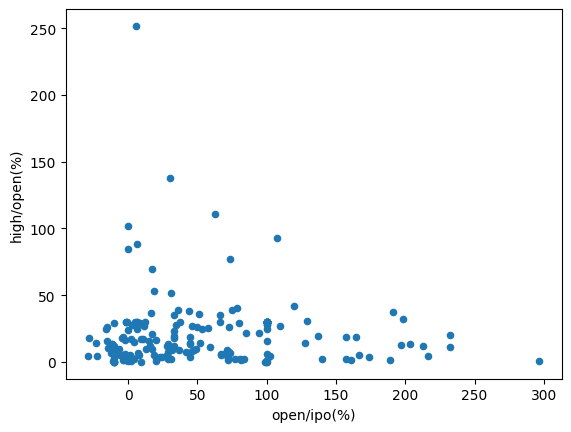

In [54]:
from matplotlib import pyplot as plt
target = data[['시초/공모(%)', '고가/시가(%)']]

target.plot.scatter(x='시초/공모(%)', y='고가/시가(%)')
plt.xlabel('open/ipo(%)')
plt.ylabel('high/open(%)')